# CatBoost basics

For this homework will use dataset Amazon Employee Access Challenge from [Kaggle](https://www.kaggle.com) competition for our experiments. Data can be downloaded [here](https://www.kaggle.com/c/amazon-employee-access-challenge/data).

As a result of this tutorial you need to provide a tsv file with answers.
There are 17 questions in this tutorial. The resulting tsv file should consist of 17 lines, each line should contain the number of the question, an answer to it and a tab separater between them. Questions are numbered from 1 to 17.
See an example of the resulting file here.

## Reading the data

Let's first download the data and put it to folder `amazon`. Now we will read this data from file.

In [ ]:
!git clone https://github.com/hse-aml/competitive-data-science

fatal: destination path 'competitive-data-science' already exists and is not an empty directory.


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test (1).csv
Saving train.csv to train (1).csv


In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=4)
import catboost
from catboost import datasets
from catboost import *

import requests
import json
import numpy as np
from collections import OrderedDict

def array_to_hash(x):
    x_tupled = None
    if type(x) == list:
        x_tupled = tuple(x)
    elif type(x) == np.ndarray:
        x_tupled = tuple(list(x.flatten()))
    elif type(x) == tuple:
        x_tupled = x
    else:
        raise RuntimeError('unexpected type of input: {}'.format(type(x)))
    return hash(tuple(map(float, x_tupled)))

def almostEqual(x, y):
    return abs(x - y) < 1e-3


class Grader(object):
    def __init__(self):
        self.submission_page = 'https://www.coursera.org/api/onDemandProgrammingScriptSubmissions.v1'
        self.assignment_key = '2ksCns1AEeiQGAocUzg3rg'
        self.parts = OrderedDict([
                    ('6IBOp', 'negative_samples'),
                    ('KFgw6', 'positive_samples'),
                    ('AdVS6', 'resource_unique_values'),
                    ('Qmiy0', 'logloss_mean'),
                    ('5UJeq', 'logloss_std'),
                    ('3JTkU', 'accuracy_6'),
                    ('N0VEy', 'best_model_name'),
                    ('xmS1J', 'num_trees'),
                    ('ztywb', 'mean_logloss_cv'),
                    ('FaDLS', 'logloss_std_1'),
                    ('jFOSe', 'iterations_overfitting'),
                    ('inxm1', 'auc_550'),
                    ('QRox8', 'feature_importance_top3'),
                    ('4t0CV', 'most_important'),
                    ('C8JOy', 'shap_influence'),
                    ('R50wr', 'speedup'),
                    ('eA8X5', 'final_auc')])
        self.answers = {key: None for key in self.parts}

    @staticmethod
    def ravel_output(output):
        '''
           If student accedentally submitted np.array with one
           element instead of number, this function will submit
           this number instead
        '''
        if isinstance(output, np.ndarray) and output.size == 1:
            output = output.item(0)
        return output

    def submit(self, email, token):
        submission = {
                    "assignmentKey": self.assignment_key, 
                    "submitterEmail": email, 
                    "secret": token, 
                    "parts": {}
                  }
        for part, output in self.answers.items():
            if output is not None:
                submission["parts"][part] = {"output": output}
            else:
                submission["parts"][part] = dict()
        request = requests.post(self.submission_page, data=json.dumps(submission))
        response = request.json()
        if request.status_code == 201:
            print('Submitted to Coursera platform. See results on assignment page!')
        elif u'details' in response and u'learnerMessage' in response[u'details']:
            print(response[u'details'][u'learnerMessage'])
        else:
            print("Unknown response from Coursera: {}".format(request.status_code))
            print(response)

    def status(self):
        print("You want to submit these numbers:")
        for part_id, part_name in self.parts.items():
            answer = self.answers[part_id]
            if answer is None:
                answer = '-'*10
            print("Task {}: {}".format(part_name, answer))
               
    def submit_part(self, part, output):
        self.answers[part] = output
        print("Current answer for task {} is: {}".format(self.parts[part], output))

    def submit_tag(self, tag, output):
        part_id = [k for k, v in self.parts.items() if v == tag]
        if len(part_id)!=1:
            raise RuntimeError('cannot match tag with part_id: found {} matches'.format(len(part_id)))
        part_id = part_id[0]
        self.submit_part(part_id, str(self.ravel_output(output)))


In [ ]:
train_df, test_df = catboost.datasets.amazon()
train_df.head()

ACTION  RESOURCE  MGR_ID  ...  ROLE_FAMILY_DESC  ROLE_FAMILY  ROLE_CODE
0       1     39353   85475  ...            117906       290919     117908
1       1     17183    1540  ...            118536       308574     118539
2       1     36724   14457  ...            267952        19721     117880
3       1     36135    5396  ...            240983       290919     118322
4       1     42680    5905  ...            123932        19793     119325

[5 rows x 10 columns]

In [ ]:
grader = Grader()

## Preparing your data

Label values extraction

In [ ]:
y = train_df.ACTION
X = train_df.drop('ACTION', axis=1)

Categorical features declaration

In [ ]:
cat_features = list(range(0, X.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8]


Now it makes sense to ananyze the dataset.
First you need to calculate how many positive and negative objects are present in the train dataset.

**Question 1:**

How many negative objects are present in the train dataset X?

In [ ]:
zero_count = y.value_counts().values[1]
grader.submit_tag('negative_samples', zero_count)

Current answer for task negative_samples is: 1897


**Question 2:**

How many positive objects are present in the train dataset X?

In [ ]:
one_count = y.value_counts().values[0]
grader.submit_tag('positive_samples', one_count)

Current answer for task positive_samples is: 30872


In [ ]:
print('Zero count = ' + str(zero_count) + ', One count = ' + str(one_count))

Zero count = 1897, One count = 30872


Now for every feature you need to calculate number of unique values of this feature.

**Question 3:**
    
How many unique values has feature RESOURCE?

In [ ]:
unique_vals_for_RESOURCE = train_df['RESOURCE'].value_counts().shape[0]
grader.submit_tag('resource_unique_values', unique_vals_for_RESOURCE)

Current answer for task resource_unique_values is: 7518


Now we can create a Pool object. This type is used for datasets in CatBoost. You can also use numpy array or dataframe. Working with Pool class is the most efficient way in terms of memory and speed. We recommend to create Pool from file in case if you have your data on disk or from FeaturesData if you use numpy.

In [ ]:
import numpy as np
from catboost import Pool

pool1 = Pool(data=X, label=y, cat_features=cat_features)
pool2 = Pool(data='train.csv', delimiter=',', has_header=True)
pool3 = Pool(data=X, cat_features=cat_features)

print('Dataset shape')
print('dataset 1:' + str(pool1.shape) + '\ndataset 2:' + str(pool2.shape)  + '\ndataset 3:' + str(pool3.shape))

print('\n')
print('Column names')
print('dataset 1: ')
print(pool1.get_feature_names()) 
print('\ndataset 2:')
print(pool2.get_feature_names())
print('\ndataset 3:')
print(pool3.get_feature_names())

Dataset shape
dataset 1:(32769, 9)
dataset 2:(32769, 9)
dataset 3:(32769, 9)


Column names
dataset 1: 
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']

dataset 2:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']

dataset 3:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']


## Split your data into train and validation

When you will be training your model, you will have to detect overfitting and select best parameters. To do that you need to have a validation dataset.
Normally you would be using some random split, for example
`train_test_split` from `sklearn.model_selection`.
But for the purpose of this homework the train part will be the first 80% of the data and the evaluation part will be the last 20% of the data.

In [ ]:
train_count = int(X.shape[0] * 0.8)

X_train = X.iloc[:train_count,:]
y_train = y[:train_count]
X_validation = X.iloc[train_count:, :]
y_validation = y[train_count:]

## Train your model

Now we will train our first model.

In [ ]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=5,
    random_seed=0,
    learning_rate=0.1
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    logging_level='Silent'
)
print('Model is fitted: ' + str(model.is_fitted()))
print('Model params:')
print(model.get_params())

Model is fitted: True
Model params:
{'random_seed': 0, 'learning_rate': 0.1, 'iterations': 5}


## Stdout of the training

You can see in stdout values of the loss function on each iteration, or on each k-th iteration.
You can also see how much time passed since the start of the training and how much time is left.

In [ ]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=15,
    verbose=3
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
)

Learning rate set to 0.441257
0:	learn: 0.4218644	test: 0.4238882	best: 0.4238882 (0)	total: 9.55ms	remaining: 134ms
3:	learn: 0.2323838	test: 0.2357560	best: 0.2357560 (3)	total: 67.2ms	remaining: 185ms
6:	learn: 0.1868476	test: 0.1795406	best: 0.1795406 (6)	total: 121ms	remaining: 138ms
9:	learn: 0.1786571	test: 0.1689628	best: 0.1689628 (9)	total: 173ms	remaining: 86.5ms
12:	learn: 0.1731382	test: 0.1639559	best: 0.1639559 (12)	total: 229ms	remaining: 35.2ms
14:	learn: 0.1720164	test: 0.1623020	best: 0.1623020 (14)	total: 261ms	remaining: 0us

bestTest = 0.1623019855
bestIteration = 14



## Random seed

If you don't specify random_seed then random seed will be set to a new value each time.
After the training has finished you can look on the value of the random seed that was set.
If you train again with this random_seed, you will get the same results.

In [ ]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=5
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
)

Learning rate set to 0.5
0:	learn: 0.3963217	test: 0.3986149	best: 0.3986149 (0)	total: 10.4ms	remaining: 41.5ms
1:	learn: 0.2934864	test: 0.2972563	best: 0.2972563 (1)	total: 19.3ms	remaining: 29ms
2:	learn: 0.2495301	test: 0.2543897	best: 0.2543897 (2)	total: 29.1ms	remaining: 19.4ms
3:	learn: 0.2235704	test: 0.2267986	best: 0.2267986 (3)	total: 47.5ms	remaining: 11.9ms
4:	learn: 0.2003235	test: 0.1962958	best: 0.1962958 (4)	total: 64.7ms	remaining: 0us

bestTest = 0.1962957582
bestIteration = 4



In [ ]:
random_seed = model.random_seed_
print('Used random seed = ' + str(random_seed))
model = CatBoostClassifier(
    iterations=5,
    random_seed=random_seed
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
)

Used random seed = 0
Learning rate set to 0.5
0:	learn: 0.3963217	test: 0.3986149	best: 0.3986149 (0)	total: 10.4ms	remaining: 41.5ms
1:	learn: 0.2934864	test: 0.2972563	best: 0.2972563 (1)	total: 19.4ms	remaining: 29ms
2:	learn: 0.2495301	test: 0.2543897	best: 0.2543897 (2)	total: 29.7ms	remaining: 19.8ms
3:	learn: 0.2235704	test: 0.2267986	best: 0.2267986 (3)	total: 54.7ms	remaining: 13.7ms
4:	learn: 0.2003235	test: 0.1962958	best: 0.1962958 (4)	total: 71.7ms	remaining: 0us

bestTest = 0.1962957582
bestIteration = 4



Try training 10 models with parameters and calculate mean and the standart deviation of Logloss error on validation dataset.

**Question 4:**

What is the mean value of the Logloss metric on validation dataset (X_validation, y_validation) after 10 times training `CatBoostClassifier` with different random seeds in the following way:

`model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.1,
    random_seed={my_random_seed}
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
)
`

In [ ]:
for i in range(10):
  model = CatBoostClassifier( iterations=300, learning_rate=0.1, random_seed=i ) 
  model.fit( X_train, y_train, cat_features=cat_features, eval_set=(X_validation, y_validation), )

0:	learn: 0.5790122	test: 0.5797377	best: 0.5797377 (0)	total: 20.9ms	remaining: 6.26s
1:	learn: 0.4926882	test: 0.4940422	best: 0.4940422 (1)	total: 58.4ms	remaining: 8.7s
2:	learn: 0.4262945	test: 0.4277599	best: 0.4277599 (2)	total: 97.9ms	remaining: 9.69s
3:	learn: 0.3762555	test: 0.3777218	best: 0.3777218 (3)	total: 152ms	remaining: 11.2s
4:	learn: 0.3396747	test: 0.3417070	best: 0.3417070 (4)	total: 170ms	remaining: 10.1s
5:	learn: 0.3099710	test: 0.3121170	best: 0.3121170 (5)	total: 211ms	remaining: 10.4s
6:	learn: 0.2891905	test: 0.2917690	best: 0.2917690 (6)	total: 230ms	remaining: 9.64s
7:	learn: 0.2733016	test: 0.2762425	best: 0.2762425 (7)	total: 251ms	remaining: 9.14s
8:	learn: 0.2547005	test: 0.2563450	best: 0.2563450 (8)	total: 309ms	remaining: 9.98s
9:	learn: 0.2403536	test: 0.2406058	best: 0.2406058 (9)	total: 364ms	remaining: 10.6s
10:	learn: 0.2293277	test: 0.2286916	best: 0.2286916 (10)	total: 409ms	remaining: 10.8s
11:	learn: 0.2209746	test: 0.2198225	best: 0.21982

KeyboardInterrupt: ignored

In [ ]:
listm = np.array([0.1384373308, 0.1391594286, 0.1381751503, 0.1370272511, 0.1384847454, 0.1374441568, 0.1375378563, 0.1375743122, 0.1384419851, 0.1382562261])
mean = listm.mean()
grader.submit_tag('logloss_mean', mean)

Current answer for task logloss_mean is: 0.13805384427


**Question 5:**

What is the standard deviation of it?

In [ ]:
stddev = listm.std()
grader.submit_tag('logloss_std', stddev)

Current answer for task logloss_std is: 0.0006068927594162512


## Metrics calculation and graph plotting

When experimenting with Jupyter notebook you can see graphs of different errors during training.
To do that you need to use `plot=True` parameter.

In [ ]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=50,
    random_seed=63,
    learning_rate=0.1,
    custom_loss=['Accuracy']
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    logging_level='Silent',
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

**Question 6:**

What is the value of the accuracy metric value on evaluation dataset after training with parameters `iterations=50`, `random_seed=63`, `learning_rate=0.1`?

In [ ]:
accuracy = 0.9539213
grader.submit_tag('accuracy_6', accuracy)

Current answer for task accuracy_6 is: 0.9539213


## Model comparison

In [ ]:
model1 = CatBoostClassifier(
    learning_rate=0.5,
    iterations=1000,
    random_seed=64,
    train_dir='learning_rate_0.5',
    custom_loss = ['Accuracy']
)

model2 = CatBoostClassifier(
    learning_rate=0.05,
    iterations=1000,
    random_seed=64,
    train_dir='learning_rate_0.05',
    custom_loss = ['Accuracy']
)
model1.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=100
)
model2.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=100
)

0:	learn: 0.3007996	test: 0.3044268	best: 0.3044268 (0)	total: 18.8ms	remaining: 18.8s


KeyboardInterrupt: ignored

In [ ]:
from catboost import MetricVisualizer
MetricVisualizer(['learning_rate_0.05', 'learning_rate_0.5']).start()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

**Question 7:**

Try training these models for 1000 iterations. Which model will give better best resulting Accuracy on validation dataset?
By best resulting accuracy we mean accuracy on best iteration, which might be not the last iteration.

In [ ]:
best_model_name =  'learning_rate_0.05'
grader.submit_tag('best_model_name', best_model_name)

Current answer for task best_model_name is: learning_rate_0.05


## Best iteration

If a validation dataset is present then after training, the model is shrinked to a number of trees when it got best evaluation metric value on validation dataset.
By default evaluation metric is the optimized metric. But you can set evaluation metric to some other metric.
In the example below evaluation metric is `Accuracy`.

In [ ]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=100,
    random_seed=63,
    learning_rate=0.5,
    eval_metric='Accuracy'
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    logging_level='Silent',
    plot=True
)

In [ ]:
print('Tree count: ' + str(model.tree_count_))

If you don't want the model to be shrinked, you can set `use_best_model=False`

In [ ]:
model = CatBoostClassifier(
    iterations=100,
    random_seed=63,
    learning_rate=0.5,
    eval_metric='Accuracy',
    use_best_model=False
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    logging_level='Silent',
    plot=True
)
print('Tree count: ' + str(model.tree_count_))

**Question 8:**
    
What will be the number of trees in the resulting model after training with validation dataset with parameters `iterations=100`, ` learning_rate=0.5`, `eval_metric='Accuracy'` and with parameter `use_best_model=False`

In [ ]:
tree_count = 100
grader.submit_tag('num_trees', tree_count)

Current answer for task num_trees is: 100


## Cross-validation

The next functionality you need to know about is cross-validation.
For unbalanced datasets stratified cross-validation can be useful.

In [ ]:
from catboost import cv

params = {}
params['loss_function'] = 'Logloss'
params['iterations'] = 80
params['custom_loss'] = 'AUC'
params['random_seed'] = 63
params['learning_rate'] = 0.5

cv_data = cv(
    params = params,
    pool = Pool(X, label=y, cat_features=cat_features),
    fold_count=5,
    inverted=False,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=True,
    verbose=False
)

Cross-validation returns specified metric values on every iteration (or every k-th iteration, if you specify so)

In [ ]:
print(cv_data[0:4])

Let's look on mean value and standard deviation of Logloss for cv on best iteration.

In [ ]:
best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])

print('Best validation Logloss score, not stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)

Best validation Logloss score, not stratified: 0.1571±0.0028 on step 50


**Question 9:**

Try running stratified cross-validation with the same parameters. What will be mean of Logloss metric on test of the stratified cross-validation on the best iteration?

In [ ]:
mean_on_best_iteration = 0.1571
grader.submit_tag('mean_logloss_cv', mean_on_best_iteration)

Current answer for task mean_logloss_cv is: 0.1571


**Question 10:**

Try running stratified cross-validation with the same parameters. What will be the standard deviation of Logloss metric of the stratified cross-validation on the best iteration?

In [ ]:
std_on_best_iteration = 0.0028
grader.submit_tag('logloss_std_1', std_on_best_iteration)

Current answer for task logloss_std_1 is: 0.0028


## Overfitting detector

A useful feature of the library is overfitting detector.
Let's try training the model with early stopping.

In [ ]:
model_with_early_stop = CatBoostClassifier(
    iterations=200,
    random_seed=63,
    learning_rate=0.5,
    od_type='Iter',
    od_wait=20,
    eval_metric = 'AUC'
)
model_with_early_stop.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    logging_level='Silent',
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

**Question 11:**

Now try training the model with the same parameters and with overfitting detector, but with `eval_metric='AUC'`
What will be the number of iterations after which the training will stop?
(Not the number of trees in the resulting model, but the number of iterations that the algorithm will perform befor training).

In [ ]:
iterations_count = 84
grader.submit_tag('iterations_overfitting', iterations_count)

Current answer for task iterations_overfitting is: 84


## Snapshotting

If you train for long time, for example for several hours, you need to save snapshots.
Otherwise if your laptop or your server will reboot, you will loose all the progress.
To do that you need to specify `snapshot_file` parameter.
Try running the code below and interrupting the kernel after short time.
Then try running the same cell again.
The training will start from the iteration when the training was interrupted.
Note that all additional files are written by default into `catboost_info` directory. It can be changed using `train_dir` parameter. So the snapshot file will be there.

In [ ]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=40,
    save_snapshot=True,
    snapshot_file='snapshot.bkp',
    random_seed=43
)
model.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    logging_level='Verbose'
)

Learning rate set to 0.288002
0:	learn: 0.4998892	test: 0.5009131	best: 0.5009131 (0)	total: 19.5ms	remaining: 761ms
1:	learn: 0.3928966	test: 0.3947405	best: 0.3947405 (1)	total: 38.5ms	remaining: 731ms
2:	learn: 0.3273849	test: 0.3293347	best: 0.3293347 (2)	total: 54.3ms	remaining: 669ms
3:	learn: 0.2861754	test: 0.2886289	best: 0.2886289 (3)	total: 64.2ms	remaining: 577ms
4:	learn: 0.2600956	test: 0.2633799	best: 0.2633799 (4)	total: 71.8ms	remaining: 503ms
5:	learn: 0.2409059	test: 0.2435218	best: 0.2435218 (5)	total: 83.5ms	remaining: 473ms
6:	learn: 0.2289714	test: 0.2311302	best: 0.2311302 (6)	total: 91.2ms	remaining: 430ms
7:	learn: 0.2117902	test: 0.2093182	best: 0.2093182 (7)	total: 103ms	remaining: 414ms
8:	learn: 0.2016288	test: 0.1975972	best: 0.1975972 (8)	total: 119ms	remaining: 412ms
9:	learn: 0.1953748	test: 0.1900229	best: 0.1900229 (9)	total: 136ms	remaining: 409ms
10:	learn: 0.1905659	test: 0.1839534	best: 0.1839534 (10)	total: 152ms	remaining: 401ms
11:	learn: 0.18

## Model predictions

There are multiple ways to do predictions.
The easiest one is to call predict or predict_proba.
You also can make predictions using C++ code. For that see [documentation](https://tech.yandex.com/catboost/doc/dg/concepts/c-plus-plus-api-docpage/).

In [ ]:
print(model.predict_proba(data=X_validation))

[[0.0106 0.9894]
 [0.0212 0.9788]
 [0.0128 0.9872]
 ...
 [0.011  0.989 ]
 [0.3201 0.6799]
 [0.0403 0.9597]]


In [ ]:
print(model.predict(data=X_validation))

[1 1 1 ... 1 1 1]


For binary classification resulting value is not necessary a value in `[0,1]`. It is some numeric value. To get the probability out of this value you need to calculate sigmoid of that value.

In [ ]:
raw_pred = model.predict(data=X_validation, prediction_type='RawFormulaVal')
print(raw_pred)

[4.536  3.8344 4.3463 ... 4.4948 0.7533 3.171 ]


In [ ]:
import math
def sigmoid(x):
    return 1 / (1 + math.exp(-x))
probabilities = [sigmoid(x) for x in raw_pred]
print(np.array(probabilities))

[0.9894 0.9788 0.9872 ... 0.989  0.6799 0.9597]


## Staged prediction

CatBoost also supports staged prediction - when you want to have a prediction on each object on each iteration (or on each k-th iteration). This can be used if you want to calculate the values of some custom metric using the predictions.

In [ ]:
predictions_gen = model.staged_predict_proba(data=X_validation, ntree_start=0, ntree_end=5, eval_period=1)
for iteration, predictions in enumerate(predictions_gen):
    print('Iteration ' + str(iteration) + ', predictions:')
    print(predictions)

Iteration 0, predictions:
[[0.3752 0.6248]
 [0.3752 0.6248]
 [0.3752 0.6248]
 ...
 [0.3752 0.6248]
 [0.3752 0.6248]
 [0.3752 0.6248]]
Iteration 1, predictions:
[[0.2887 0.7113]
 [0.2887 0.7113]
 [0.2887 0.7113]
 ...
 [0.2887 0.7113]
 [0.2887 0.7113]
 [0.2887 0.7113]]
Iteration 2, predictions:
[[0.2232 0.7768]
 [0.2345 0.7655]
 [0.2232 0.7768]
 ...
 [0.2232 0.7768]
 [0.2434 0.7566]
 [0.2345 0.7655]]
Iteration 3, predictions:
[[0.1763 0.8237]
 [0.1875 0.8125]
 [0.1763 0.8237]
 ...
 [0.1763 0.8237]
 [0.2028 0.7972]
 [0.1949 0.8051]]
Iteration 4, predictions:
[[0.144  0.856 ]
 [0.1535 0.8465]
 [0.144  0.856 ]
 ...
 [0.144  0.856 ]
 [0.1666 0.8334]
 [0.1598 0.8402]]


## Metric evaluation on a new dataset

You can also calculate metrics directly after training.

In [ ]:
metrics = model.eval_metrics(data=pool1, metrics=['Logloss','AUC'], plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
print('AUC values:')
print(np.array(metrics['AUC']))

AUC values:
[0.5052 0.5074 0.639  0.6435 0.6435 0.6705 0.737  0.8662 0.9039 0.905
 0.9141 0.9216 0.923  0.9296 0.9336 0.9371 0.9412 0.9413 0.9421 0.9426
 0.9443 0.9456 0.9456 0.9456 0.9456 0.9455 0.9454 0.9452 0.9458 0.946
 0.9465 0.9469 0.9472 0.947  0.9468 0.9467 0.9467 0.9471 0.947  0.947 ]


**Question 12:**

Now train a model in the following way:

`
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    random_seed=43
)
model.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    logging_level='Verbose'
)
`

What will be the AUC value on 550 iteration if evaluation metrics on the initial X dataset?

In [ ]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    random_seed=43,
    eval_metric='AUC'
)
model.fit(
    X_train, y_train,
    eval_set=(X, y),
    cat_features=cat_features,
    logging_level='Verbose'
)

0:	test: 0.4998777	best: 0.4998777 (0)	total: 46.1ms	remaining: 46s
1:	test: 0.6182901	best: 0.6182901 (1)	total: 101ms	remaining: 50.3s
2:	test: 0.6183522	best: 0.6183522 (2)	total: 138ms	remaining: 46s
3:	test: 0.6296716	best: 0.6296716 (3)	total: 182ms	remaining: 45.3s
4:	test: 0.6446950	best: 0.6446950 (4)	total: 215ms	remaining: 42.8s
5:	test: 0.6462447	best: 0.6462447 (5)	total: 253ms	remaining: 41.9s
6:	test: 0.6949169	best: 0.6949169 (6)	total: 306ms	remaining: 43.4s
7:	test: 0.7103858	best: 0.7103858 (7)	total: 339ms	remaining: 42.1s
8:	test: 0.7100489	best: 0.7103858 (7)	total: 380ms	remaining: 41.9s
9:	test: 0.7196460	best: 0.7196460 (9)	total: 434ms	remaining: 42.9s
10:	test: 0.7196460	best: 0.7196460 (9)	total: 452ms	remaining: 40.6s
11:	test: 0.7192001	best: 0.7196460 (9)	total: 481ms	remaining: 39.6s
12:	test: 0.7905544	best: 0.7905544 (12)	total: 535ms	remaining: 40.6s
13:	test: 0.7829344	best: 0.7905544 (12)	total: 597ms	remaining: 42.1s
14:	test: 0.7912926	best: 0.791

In [ ]:
auc_value = 0.9851196
grader.submit_tag('auc_550', auc_value)

Current answer for task auc_550 is: 0.9851196


## Feature importances

Now we will learn how to understand which features are the most important ones. Let's first train the model that will not use feature combinations. To forbid feature combinations you need to use 'max_ctr_complexity=1'. This will speed up the training by a lot, but it will reduce the resulting quality. 

In [ ]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=300,
    max_ctr_complexity=4,
    random_seed=43
)
model.fit(
    X, y,
    cat_features=cat_features,
    verbose=50
)

Learning rate set to 0.137885
0:	learn: 0.5382281	total: 73ms	remaining: 21.8s
50:	learn: 0.1494065	total: 3.23s	remaining: 15.8s
100:	learn: 0.1423648	total: 6.86s	remaining: 13.5s
150:	learn: 0.1368037	total: 10.5s	remaining: 10.4s
200:	learn: 0.1324257	total: 14.1s	remaining: 6.96s
250:	learn: 0.1283281	total: 17.9s	remaining: 3.49s
299:	learn: 0.1251284	total: 21.5s	remaining: 0us


Let's see which features are most important for the model without feature combinations.

In [ ]:
importances = model.get_feature_importance(prettified=True)
print(importances)

         Feature Id  Importances
0          RESOURCE    20.963067
1            MGR_ID    17.835245
2     ROLE_DEPTNAME    15.684628
3  ROLE_FAMILY_DESC    11.586115
4     ROLE_ROLLUP_2    10.996416
5        ROLE_TITLE     6.214463
6     ROLE_ROLLUP_1     6.100384
7         ROLE_CODE     5.484116
8       ROLE_FAMILY     5.135566


** Question 13: **

Try training the model without the restriction of combinations, with other parameters set to the same values.
What will be top 3 most important features for this model?

In [ ]:
top3 = ['RESOURCE','MGR_ID','ROLE_DEPTNAME']# You should provide comma separated list of strings. Each string should be in single quotes. All list should be in square brackets.
grader.submit_tag('feature_importance_top3', top3)

Current answer for task feature_importance_top3 is: ['RESOURCE', 'MGR_ID', 'ROLE_DEPTNAME']


## Shap values

Let's train the model one more time.

In [ ]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=300,
    max_ctr_complexity=1,
    random_seed=43
)
model.fit(
    X, y,
    cat_features=cat_features,
    verbose=50
)

Learning rate set to 0.137885
0:	learn: 0.5379892	total: 42.4ms	remaining: 12.7s
50:	learn: 0.1642268	total: 1.78s	remaining: 8.67s
100:	learn: 0.1579621	total: 3.58s	remaining: 7.06s
150:	learn: 0.1533024	total: 5.39s	remaining: 5.32s
200:	learn: 0.1486749	total: 7.24s	remaining: 3.56s
250:	learn: 0.1446334	total: 9.05s	remaining: 1.77s
299:	learn: 0.1411890	total: 10.8s	remaining: 0us


The library provides a way to understand which features are important for a given object.
Let's take a look on the whole dataset X and analyze the influence of different features on the objects from this dataset.
We will now calculate importances for each object. After that we will visualize these importances.

In [ ]:
pool1 = Pool(data=X, label=y, cat_features=cat_features)
shap_values = model.get_feature_importance(data=pool1, fstr_type='ShapValues', verbose=10000)
print(shap_values.shape)

Processing trees...
128/300 trees processed	passed time: 161ms	remaining time: 216ms
300/300 trees processed	passed time: 399ms	remaining time: 0us
Processing documents...
128/32769 documents processed	passed time: 2.74ms	remaining time: 698ms
10112/32769 documents processed	passed time: 164ms	remaining time: 368ms
20096/32769 documents processed	passed time: 333ms	remaining time: 210ms
30080/32769 documents processed	passed time: 495ms	remaining time: 44.3ms
(32769, 10)


Let's look on the prediction of the model for 0-th object. The raw prediction is not the probability, to calculate probability from raw prediction you need to calculate sigmoid(raw_prediction).

In [ ]:
test_objects = [X.iloc[0:1]]

for obj in test_objects:
    print('Probability of class 1 = {:.4f}'.format(model.predict_proba(obj)[0][1]))
    print('Formula raw prediction = {:.4f}'.format(model.predict(obj, prediction_type='RawFormulaVal')[0]))
    print('\n')

Probability of class 1 = 0.9948
Formula raw prediction = 5.2546




Sum of all shap values are equal to the resulting raw formula predition.
We can see on the graph that will be output below that there is a base value, which is equal for all the objects.
And almost all the feature have positive influence on this object. The biggest step to the right is because of the feature called 'MGR_ID'.

In [ ]:
!pip install shap==0.18.0
import shap
shap.initjs()
shap.force_plot(shap_values[0,:], X.iloc[0,:])

** Question 14: **

What is the most important feature for 91-th object

In [ ]:
most_important_feature = 'ROLE_CODE'
grader.submit_tag('most_important', most_important_feature)

Current answer for task most_important is: ROLE_CODE


** Question 15: **

Does it have positive or negative influence? Answer 1 if positive and -1 if negative.

In [ ]:
influence_sign = -1
grader.submit_tag('shap_influence', influence_sign)

Current answer for task shap_influence is: -1


You can also view aggregated information about the influences on the whole dataset.

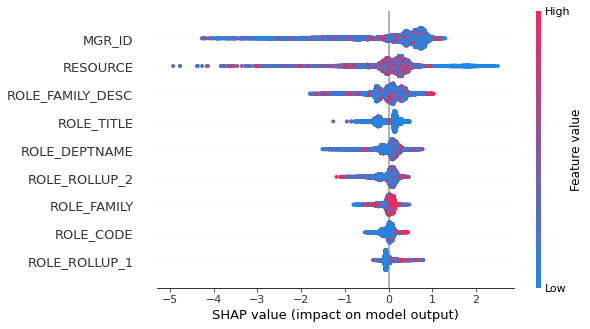

In [ ]:
shap.summary_plot(shap_values, X)

From this graph you can see that values of MGR_ID and RESOURCE features have a large negative impact for many objects.
You can also see that RESOURCE has largest positive impact for many objects.

## Saving the model

You can save your model as a binary file. It is also possible to save the model as Python or C++ code.
If you save the model as a binary file you can then look on the parameters with which the model was trained, including learning_rate and random_seed that are set automatically if you don't specify them.

In [ ]:
my_best_model = CatBoostClassifier(iterations=10)
my_best_model.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False
)
my_best_model.save_model('catboost_model.bin')

In [ ]:
my_best_model.load_model('catboost_model.bin')
print(my_best_model.get_params())
print(my_best_model.random_seed_)
print(my_best_model.learning_rate_)

## Hyperparameter tunning

You can tune the parameters to get better speed or better quality.
Here is the list of parameters that are important for speed and accuracy.

### Training speed

Here is the list of parameters that are important for speeding up the training.
Note that changing this parameters might decrease the quality.
1. iterations + learning rate
By default we train for 1000 iterations. You can decrease this number, but if you decrease the number of iterations you need to increase learning rate so that the process converges. We set learning rate by default dependent on number of iterations and on your dataset, so you might just use default learning rate. But if you want to tune it, you need to know - the more iterations you have, the less should be the learning rate.

2. boosting_type
By default we use Ordered boosting for smaller datasets where we want to fight overfitting. This is expensive in terms of computations. You can set boosting_type to Plain to disable this.

3. bootstrap_type
By default we sample weights from exponential distribution. It is faster to use sampling from Bernoulli distribution. To enable that use bootstrap_type='Bernoulli' + subsample={some value < 1}

4. one_hot_max_size
By default we use one-hot encoding only for categorical features with little amount of different values. For all other categorical features we calculate statistics. This is expensive, and one-hot encoding is cheep. So you can speed up the training by setting one_hot_max_size to some bigger value

5. rsm
This parameter is very important, because it speeds up the training and does not affect the quality. So you should definitely use it, but only in case if you have hundreds of features.
If you have little amount of features it's better not to use this parameter.
If you have many features then the rule is the following: you decrease rsm, for example, you set rsm=0.1. With this rsm value the training needs more iterations to converge. Usually you need about 20% more iterations. But each iteration will be 10x faster. So the resulting training time will be faster even though you will have more trees in the resulting model.

6. leaf_estimation_iterations
This parameter is responsible for calculating leaf values after you have already selected tree structure.
If you have little amount of features, for example 8 or 10 features, then this place starts to be the bottle-neck.
Default value for this parameter depends on the training objective, you can try setting it to 1 or 5, and if you have little amount of features, this might speed up the training.

7. max_ctr_complexity
By default catboost generates categorical feature combinations in a greedy way.
This is time consuming, you can disable that by setting max_ctr_complexity=1 or by allowing only combinations of 2 features by setting max_ctr_complexity=2.
This will speed up the training only if you have categorical features.

8. If you are training the model on GPU, you can try decreasing border_count. This is the number of splits considered for each feature. By default it's set to 128, but you can try setting it to 32. In many cases it will not degrade the quality of the model and will speed up the training by a lot. 

In [ ]:
from catboost import CatBoost
fast_model = CatBoostClassifier(
    random_seed=63,
    iterations=150,
    learning_rate=0.01,
    boosting_type='Plain',
    bootstrap_type='Bernoulli',
    subsample=0.5,
    one_hot_max_size=20,
    rsm=0.5,
    leaf_estimation_iterations=5,
    max_ctr_complexity=1,
    border_count=32)

fast_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    logging_level='Silent',
    plot=True
)

** Question 16: **

Try tunning the speed of the algorithm. What is the maximum speedup you could get by changing these parameters without decreasing of AUC on best iteration on eval dataset compared to AUC on best iteration after training with default parameters and random seed = 0?
The answer shoud be a number, for example 2.7 means you got 2.7 times speedup.

In [ ]:
speedup = 0
grader.submit_tag('speedup', speedup)

### Accuracy

The parameters listed below are important to get the best quality of the model. Try changing this parameters to improve the quality of the resulting model

In [ ]:
tunned_model = CatBoostClassifier(
    random_seed=63,
    iterations=1000,
    learning_rate=0.03,
    l2_leaf_reg=3,
    bagging_temperature=1,
    random_strength=1,
    one_hot_max_size=2,
    leaf_estimation_method='Newton',
    eval_metric = 'AUC',
    depth=7
)
tunned_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    plot=True,
    verbose=100
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5002435	best: 0.5002435 (0)	total: 67.7ms	remaining: 1m 7s
100:	test: 0.8900942	best: 0.8900942 (100)	total: 5.79s	remaining: 51.5s
200:	test: 0.9007078	best: 0.9008280 (199)	total: 13.4s	remaining: 53.2s
300:	test: 0.9027037	best: 0.9027037 (300)	total: 21.3s	remaining: 49.6s
400:	test: 0.9025649	best: 0.9030574 (329)	total: 29.6s	remaining: 44.2s
500:	test: 0.9025946	best: 0.9030574 (329)	total: 37.8s	remaining: 37.6s
600:	test: 0.9032980	best: 0.9033294 (598)	total: 46.1s	remaining: 30.6s
700:	test: 0.9041504	best: 0.9042731 (697)	total: 54.4s	remaining: 23.2s
800:	test: 0.9044680	best: 0.9045952 (787)	total: 1m 2s	remaining: 15.7s
900:	test: 0.9046696	best: 0.9048348 (824)	total: 1m 11s	remaining: 7.87s
999:	test: 0.9049199	best: 0.9052548 (934)	total: 1m 20s	remaining: 0us

bestTest = 0.9052547978
bestIteration = 934

Shrink model to first 935 iterations.


** Question 17: **

Try tunning these parameters to make AUC on eval dataset as large as possible. What is the maximum AUC value you have reached?

In [ ]:
final_auc = 0.9052547978
grader.submit_tag('final_auc', final_auc)

Current answer for task final_auc is: 0.9052547978


In [ ]:
STUDENT_EMAIL = "surya19@iiserb.ac.in"
STUDENT_TOKEN = "rvqyAUDxplZrJmq8"
grader.status()

You want to submit these numbers:
Task negative_samples: 1897
Task positive_samples: 30872
Task resource_unique_values: 7518
Task logloss_mean: 0.13805384427
Task logloss_std: 0.0006068927594162512
Task accuracy_6: 0.9539213
Task best_model_name: learning_rate_0.05
Task num_trees: 100
Task mean_logloss_cv: 0.1571
Task logloss_std_1: 0.0028
Task iterations_overfitting: 84
Task auc_550: 0.9851196
Task feature_importance_top3: ['RESOURCE', 'MGR_ID', 'ROLE_DEPTNAME']
Task most_important: ROLE_CODE
Task shap_influence: -1
Task speedup: ----------
Task final_auc: 0.9052547978


In [ ]:
grader.submit(STUDENT_EMAIL, STUDENT_TOKEN)

Submitted to Coursera platform. See results on assignment page!
